# -*- coding: utf-8 -*-
__author__ = 'Gerald Schuller'
__copyright__ = 'G.S.'


"""
Simple program to use a convolutional neural network to obtain a predictive coder,
using explicit inputs to layers, to enable skip layers.
According to: https://keras.io/getting-started/functional-api-guide/
With Pytorch
For instance according to WCLMS or prediction Boosting
Gerald Schuller, November 2018.
"""

In [1]:
# Importing necessary modules.

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import sys
#import scipy.io.wavfile as wav
import pickle
import librosa

In [6]:
# Here should load an audio file (We will not use scipy.io.wavfile). 
#Choose one file from our dataset, we already have them as a numpy array.
a = np.load('/Users/DELL/Updated_binder_enviro/all-samples/banjo/banjo_A3_very-long_forte_normal.npy')


In [3]:
# Here is the pre-process of the audio file if needed.
print(a.shape)

(153216,)


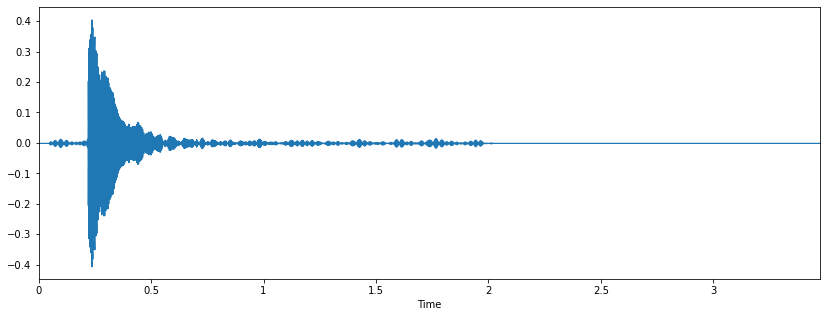

In [22]:
# Here should plot and playback the audio file.
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr=sr)

In [7]:
# Here should plot and playback the audio file
import IPython.display as ipd
ipd.Audio('/Users/DELL/Updated_binder_enviro/all-samples/banjo/banjo_A3_very-long_forte_normal.mp3')


In [1]:
# Here should be the definition of the PyTorch model


In [ ]:
# Here should be the definition of the loss function and the optimizer

In [2]:
# Here should be the training of the model

In [ ]:
# Here should be the predictions after the model is trained

In [ ]:
# Here should be the computation of the prediction errors

In [ ]:
# Here should be the plots of the results

In [ ]:
# Here you can save the model

In [3]:


L=12 #filter length
dilation=1 #Dilation: upsampling the filter impulse response, new filter length: (L-1)*dilation+1

In [4]:
def format_vector2pytorch(vector):
    
    #Function to convert a vector, like a mono audio signal, into a 3-d Tensor X that Keras expects
    #Tensor X with shape (batch, signal):
    #https://discuss.pytorch.org/t/confused-about-tensor-dimensions-and-batches/4761
    
    X = np.expand_dims(vector, axis=0)  #add batch dimension (here only 1 batch)
    X = np.expand_dims(X, axis=0)
    X=torch.from_numpy(X)
    X=X.type(torch.Tensor)
    return X


C:\Users\DELL\anaconda3\envs\BRP2\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


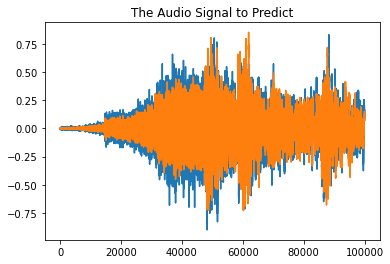

Generate Model:
Input X.shape= torch.Size([1, 1, 99988, 2])
Target Y.shape= torch.Size([1, 1, 99999, 2])
Generate Model:
Def. loss function:


C:\Users\DELL\anaconda3\envs\BRP2\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


NotImplementedError: 

In [7]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        # Define the model. 
        
        self.layer1=nn.Sequential(nn.Conv1d(in_channels=1, out_channels=1, kernel_size=L, stride=1, dilation=dilation, padding=dilation*(L-1), bias=False))
            
      #https://pytorch.org/docs/stable/nn.html#conv1d  
      # Generate a convolutional neural network model, 1 layer, no bias, linear activation function 
      # returns: Trainable object
      #concatenate data:
      #https://discuss.pytorch.org/t/concatenate-layer-output-with-additional-input-data/20462
      #input of layer: x, output of layer: out
        
        def forward(self, x):
            out = self.layer1(x)
            return out
    

if __name__ == '__main__':
    
    #Example to find prediction coefficients to minimize the mean absolute error using Python Keras
    #and 1 Convolutional layer as a predictor.
    
    #Input mono audio signal X:
    
    samplerate, audio = wav.read("trywav.wav")
    
    #samplerate, audio = wav.read("trywav.wav")
    #samplerate, audio = wav.read("fspeech.wav")
    #samplerate, audio = wav.read("WCLMSprederror.wav")
    
    audio=audio*1.0/2**15          #normalize
    
    #audio=audio*1.0/np.max(np.abs(audio)) #normalize
    
    audiosh=audio[:100000]             #shorten the signal for faster optimization,
    
    #audiosh=audio[46750:47750]
    
    plt.plot(audiosh)
    plt.title("The Audio Signal to Predict")
    plt.show()
    
    X=format_vector2pytorch(audiosh[:-((L-1)*dilation+1)])      #remove last samples 
    Y=format_vector2pytorch(audiosh[1:]) #remove first sample, for the signal to predict, 1 sample in the future
    
    print("Generate Model:")
    print("Input X.shape=", X.shape )
    print("Target Y.shape=", Y.shape)

    print("Generate Model:")
    #model = generate_model()     # Compile an neural net
    model = ConvNet()#.to('cpu')
    print("Def. loss function:")
    loss_fn = nn.MSELoss(size_average=False)
    #learning_rate = 1e-4
    optimizer = torch.optim.Adam(model.parameters())#, lr=learning_rate)
    
    
    for epoch in range(6000):
        Yred=model(X)
        loss=loss_fn(Ypred, Y)
        if epoch%100==0:
            print(epoch, loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    torch.save({'epoch': epoch,
       'model_state_dict': model.state_dict(),
       'optimizer_state_dict': optimizer.state_dict()}, "linpredweights.torch")
    
    #Processing full length signal:
    X=format_vector2pytorch(audio[:-((L-1)*dilation+1)])  #remove last samples 
    Y=format_vector2pytorch(audio[1:]) #remove first sample
    predictions=model(X) # Make Predictions based on the obtained weights, on short audio
    #mean squared predicton error:
    err= sum((predictions[0,0,:]-Y[0,0,:])**2)/max(Y.shape)
    print("mean squared prediction error=", err)
    #mean signal power:
    sigpow=sum(X[0,0,:]**2)/max(X.shape)
    print("mean signal power=", sigpow)
    print("Signal to Error Power Ratio:", sigpow/err)
    
    ww = model.state_dict()   #read obtained weights
    print("ww=", ww)
    #weight format for Conv1d:
    #[0: filter weights, 1: bias for first layer]
    #weight: filters of shape: out_channelsÃ— in_channelsgroupsÃ— kW
    weights=ww['layer1.0.weight'][0,0,:]
    
    
    print("weights= ", weights)
    #print("Predictions[0,0,:]= ", predictions[0,0,:])
    
    #print("Y=",Y)
    #convert to numpy:
    #https://discuss.pytorch.org/t/how-to-transform-variable-into-numpy/104/2
    #plt.plot(np.array(Y[0,0,:]))
    #plt.show()
    plt.plot(np.array(Y[0,0,:]))
    plt.plot(predictions.detach().numpy()[0,0,:])
    plt.legend(('Original','Predicted'))
    plt.title('The Original and Predicted Signal')
    plt.xlabel('Sample')
    plt.figure()
    plt.plot(np.array(Y[0,0,:]))
    plt.plot(predictions.detach().numpy()[0,0,:]-np.array(Y[0,0,:]))
    plt.legend(('Original','Prediction Error'))
    plt.title('The Original and Prediction Error')
    plt.xlabel('Sample')
    plt.figure()
    plt.plot(np.array(weights))
    plt.title('The Weights')
    plt.show()